In [80]:
import numpy as np
from copy import deepcopy
from scipy.linalg import norm
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt 
import pandas as pd 

In [81]:
df_full = pd.read_csv("Iris.csv")
df_full = df_full.drop(['Id'], axis=1)
df_full.head()
columns = list(df_full.columns)
features = columns[:len(columns)-1]
class_labels = list(df_full[columns[-1]])
df = df_full[features]

### Constants

In [96]:
k = 3 # Number of Clusters
MAX_ITER = 100 # Maximum number of iterations
n = len(df) # Number of data points
m = 1.7 # Fuzzy parameter # 1 -> ...
error=1e-5

![](2-1.jpg)

In [83]:
def clustersCenters(memberships):
    fuzzyMemberships = memberships ** m
    centers = (np.dot(df.T, fuzzyMemberships)/np.sum(fuzzyMemberships, axis=0)).T

    return centers

![](2-2.jpg)
![](2-3.jpg)

In [84]:
def fuzzyCov(memberships, centers):
    fm = memberships ** m
    FcovInv_Class = []
    
    for i in range(k): 
        diff = df - centers[i]
        left = np.dot((fm[:,i].reshape(-1,1)*diff).T, diff) / np.sum(fm[:,i], axis=0)
        Fcov = (np.linalg.det(left)**(-1/n)) * left
        FcovInv = np.linalg.inv(Fcov)
        FcovInv_Class.append(FcovInv)
        
    return FcovInv_Class

![](2-4.jpg)

In [85]:
def dist(memberships, centers):
    FcovInv_Class = fuzzyCov(memberships, centers)
    mahalanobis_Class = []

    for i in range(k): 
        diff = df - centers[i]
        left = np.dot(diff, FcovInv_Class[i])    
        mahalanobis = np.diag(np.dot(left, diff.T))
        mahalanobis_Class.append(mahalanobis)
    
    distance = np.array(mahalanobis_Class).T
    
    return distance

![](2-5.jpg)

In [86]:
def updateMemberships(memberships, centers):
    power = float(2/(m - 1))
    distance = dist(memberships, centers) ** power
    arr = np.zeros((n, k))
    
    for i in range(k):
        for ii in range(k):
            arr[:,ii] = ((distance[:,i]/distance[:,ii]))
        memberships[:,i] = 1/np.sum(arr,axis=1)   
        
    return memberships

### Helper Functions

In [87]:
def initMembershipMatrix():
    rnd = np.random.RandomState(42)
    memberships = rnd.rand(n, k)

    # Normalize 
    summation = memberships.sum(axis=1).reshape(-1,1)
    denominator = np.repeat(summation, k, axis=1)
    memberships = memberships/denominator

    return memberships

def getClusters(memberships):
    labels = list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(memberships[i]))
        labels.append(idx)
    return labels

In [88]:
def FuzzyGustafsonKessel():
    memberships = initMembershipMatrix()
              
    iteration = 0
    
    while iteration < MAX_ITER:
        membershipsNew = deepcopy(memberships)
        centers = clustersCenters(memberships)
        memberships = updateMemberships(memberships, centers)
        iteration += 1
        
        if norm(memberships - membershipsNew) < error:
                break
                
    labels = getClusters(memberships)
            
    return labels, centers

In [97]:
labels, centers = FuzzyGustafsonKessel()

### Ploting Results

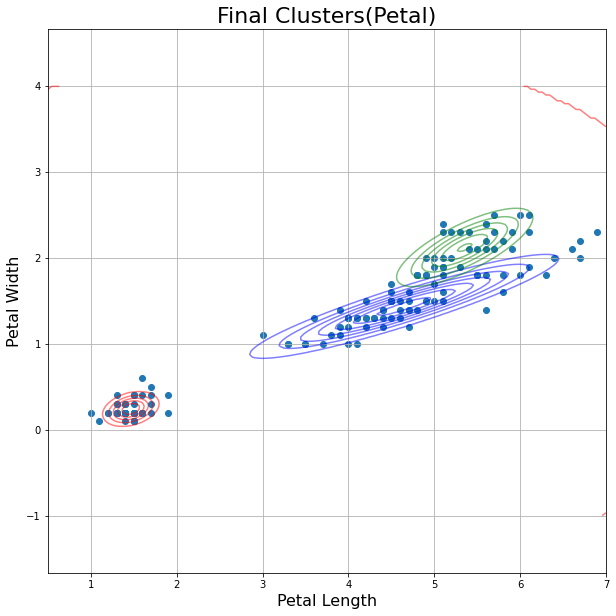

In [98]:
seto = max(set(labels[0:50]), key=labels[0:50].count)
vers = max(set(labels[50:100]), key=labels[50:100].count)
virg = max(set(labels[100:]), key=labels[100:].count)

s_mean_clus1 = np.array([centers[seto][0],centers[seto][1]])
s_mean_clus2 = np.array([centers[vers][0],centers[vers][1]])
s_mean_clus3 = np.array([centers[virg][0],centers[virg][1]])

values = np.array(labels)

searchval_seto = seto
searchval_vers = vers
searchval_virg = virg

ii_seto = np.where(values == searchval_seto)[0]
ii_vers = np.where(values == searchval_vers)[0]
ii_virg = np.where(values == searchval_virg)[0]
ind_seto = list(ii_seto)
ind_vers = list(ii_vers)
ind_virg = list(ii_virg)

sepal_df = df_full.iloc[:,0:2]
seto_df = sepal_df[sepal_df.index.isin(ind_seto)]
vers_df = sepal_df[sepal_df.index.isin(ind_vers)]
virg_df = sepal_df[sepal_df.index.isin(ind_virg)]
cov_seto = np.cov(np.transpose(np.array(seto_df)))
cov_vers = np.cov(np.transpose(np.array(vers_df)))
cov_virg = np.cov(np.transpose(np.array(virg_df)))
sepal_df = np.array(sepal_df)
x1 = np.linspace(4,8,150)  
x2 = np.linspace(1.5,4.5,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(s_mean_clus1, cov_seto)  
Z2 = multivariate_normal(s_mean_clus2, cov_vers)
Z3 = multivariate_normal(s_mean_clus3, cov_virg)

p_mean_clus1 = np.array([centers[seto][2],centers[seto][3]])
p_mean_clus2 = np.array([centers[vers][2],centers[vers][3]])
p_mean_clus3 = np.array([centers[virg][2],centers[virg][3]])
petal_df = df_full.iloc[:,2:4]
seto_df = petal_df[petal_df.index.isin(ind_seto)]
vers_df = petal_df[petal_df.index.isin(ind_vers)]
virg_df = petal_df[petal_df.index.isin(ind_virg)]
cov_seto = np.cov(np.transpose(np.array(seto_df)))
cov_vers = np.cov(np.transpose(np.array(vers_df)))
cov_virg = np.cov(np.transpose(np.array(virg_df)))
petal_df = np.array(petal_df)
x1 = np.linspace(0.5,7,150)  
x2 = np.linspace(-1,4,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(p_mean_clus1, cov_seto)  
Z2 = multivariate_normal(p_mean_clus2, cov_vers)
Z3 = multivariate_normal(p_mean_clus3, cov_virg)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(petal_df[:,0], petal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('Petal Length', fontsize=16)                                                  # X-Axis
plt.ylabel('Petal Width', fontsize=16)                                                  # Y-Axis
plt.title('Final Clusters(Petal)', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()